In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
#Import packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
import os

#Import Custom Classes
import gym
import gym_combrf

#from Source.nn_model_dqn import QNetwork
#from Source.dqn_rcv_agent import Agent, DQN_ReplayBuffer, EpsilonGreedyStrategy
#from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average

In [3]:
#create a channel variation of vectors, one for each location in environment

#create same channel variation over time for all location, as we train MAB separately for every location.
#This can then be compared with DQN with same channel variation over time.

inp_fptr = open("ch_variation_large.txt")
ch_randvals = inp_fptr.read().splitlines()
ch_randvals = [np.complex(a.replace('i','j')) for a in ch_randvals]


# Learn beamalignment using A2C without channel variation

In [289]:
# Assume LOS or NLOS throughout the environment. Do not change in between for now
from Source.nn_acmodel import Actor, Critic
from Source.dqn_rcv_agent import Agent#, DQN_ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average

#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 64             #minibatch size
GAMMA = 0.999                #discount factor
TAU = 1e-3                  #for soft update of target parameters
LR = 9e-4                   #learning rate


eps_start = 1.0
eps_end = 0.01
eps_decay = 0.986 #125e-6
episodes = 2000 #3100 train, 500 test
UPDATE_EVERY = 50

seed = 0                    #random seed number
episode_step_limit = 10

#select cuda:0 or cpu device for simulation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Choose the environment
#em = EnvManager(device, 'combrf-v7', seed)
env = gym.make('combrf-v7')
env.ant_arr = 'ula'
rx_xcov = np.array([20,-20])
rx_ycov = np.array([-20,20])
rx_zcov = np.array([41.5,81.5])
beam_param = 'beam-narrow'
beam_paramvals = np.array([])
env.set_beamparameters(beam_param, beam_paramvals)
env.set_coverage(rx_xcov,rx_ycov,rx_zcov)

state_size = env.N_tx*2+ env.N_rx*2+ env.obs_space.shape[0]
action_size = env.action_space.n
env.goal_steps = 64

#available_actions = em.num_actions_available()
random.seed(seed)
#state_size = em.state_size()
print("channel model: ",env.ch_model)
print("reflection points: ",env.sc_xyz)
print("state size: ", state_size)
print("action size: ", action_size)
#Select the strategy
#strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 140)#episodes

#Initialize the agent
#agent = Agent(strategy, state_size, available_actions, seed, device)

#Instantiate MemoryBuffer
#memory = DQN_ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)

actor_net = Actor(state_size, action_size, seed).to(device)
critic_net = Critic(state_size, seed).to(device)
print("Actor network: ",actor_net)
print("Critic network: ",critic_net)

#Initialize target_net weights to policy_net weights
#target_net.load_state_dict(policy_net.state_dict())
#target_net.eval() #Set the target_net in eval mode

#Select the optimizer
#optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)
optimizer = optim.SGD(params=actor_net.parameters(), lr=LR, momentum=0.01)
optimizer = optim.SGD(params=critic_net.parameters(), lr=LR, momentum=0.01)
#optimizerA = optim.Adam(actor_net.parameters(),lr=LR)
#optimizerC = optim.Adam(critic_net.parameters(),lr=LR)

channel model:  uma-los
reflection points:  []
state size:  35
action size:  64
Actor network:  Actor(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=35, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=256, bias=True)
  )
  (softmax): Softmax(dim=1)
  (output): Linear(in_features=256, out_features=64, bias=True)
)
Critic network:  Critic(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=35, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=256, bias=True)
  )
  (output): Linear(in_features=256, out_features=1, bias=True)
)


In [290]:
from Source.misc_fun.conversion import *

#loc_SNRexh = [0.0 for i in range(em.env.obs_space.nvec[3] * len(em.env.tx_locs)) ]
loc_SNRexh = [0.0 for i in range(len(env.tx_locs)) ]
loc_minSNRexh = [0.0 for i in range(len(env.tx_locs)) ]
loc_exhbdir = [0 for i in range(len(env.tx_locs)) ]
for loc_ndx in range(len(env.tx_locs)):
    #for tbdir_ndx in range(em.env.obs_space.nvec[3]):
    min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,min_rssi_val,max_rssi_val = env.get_minmax_exhrate(loc_ndx, ch_randvals[loc_ndx])
    #tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
    #Es = db2lin(em.env.P_tx)
    #SNR_exh = Es * np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
    #SNR_exh = Es * np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
    #exh_rate = np.log2(1 + SNR_exh)
    loc_minSNRexh[loc_ndx] = min_rssi_val#max_exh_rate#
    loc_SNRexh[loc_ndx] = max_rssi_val#max_exh_rate#
    loc_exhbdir[loc_ndx] = max_action_ndx

In [291]:
print(np.mean([np.abs(20*np.log10(np.abs(x))-20*np.log10(np.abs(y))) for x,y in zip(loc_SNRexh, loc_minSNRexh)]))

72.39450109928168


In [292]:
locndx_list = list(range(len(env.tx_locs)))
random_loc_ndices = random.sample(locndx_list, len(locndx_list))
#txdir_list = list(range(em.env.obs_space.nvec[3]))
#txdir_ndices = random.sample(txdir_list, len(txdir_list))

obs_list = []
for eps in range(episodes):
    ndx = eps % (len(env.tx_locs))
    #ndx = eps % (em.env.obs_space.nvec[3] * len(em.env.tx_locs))
    #ndx1 = int(ndx / em.env.obs_space.nvec[3])    
    #ndx2 = int(ndx % em.env.obs_space.nvec[3])
    obs_list.append((random_loc_ndices[ndx]))

In [293]:
print("Number of locations: ",len(env.tx_locs))
print("Number of actions: ", env.action_space.n)

Number of locations:  8
Number of actions:  64


## Train the A2C agent

init rate: -inf, init tx action: -1, init rx action: -1
Episode: 1, Iteration: 63
Episode 1,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -240.09046936035156, critic_loss: 3518.60791015625
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 48, exh action ndx: 13



init rate: -inf, init tx action: -1, init rx action: -1
Episode: 2, Iteration: 63
Episode 2,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -186.71408081054688, critic_loss: 3492.834228515625
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 28, exh action ndx: 20



init rate: -inf, init tx action: -1, init rx action: -1
Episode: 3, Iteration: 63
Episode 3,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -161.31289672851562, critic_loss: 3528.953857421875
TX loc: [[20.  20.  81.5]]
dqn action ndx: 23, exh action ndx: 34



init rate: -inf, init tx action: -1, init rx action: -1
Episode: 4, Iteration: 63
Episode 4,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -273

Episode 33,	 Score: -61.00, moving avg_rwd: -2.4965016841888428, actor_loss: -161.0772705078125, critic_loss: 3320.246337890625
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 61, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 34, Iteration: 28
Episode 34,	 Score: -27.00, moving avg_rwd: -2.4965016841888428, actor_loss: -67.98694610595703, critic_loss: 596.0243530273438
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 35, Iteration: 63
Episode 35,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -183.93722534179688, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 38, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 36, Iteration: 11
Episode 36,	 Score: -10.00, moving avg_rwd: -2.4965016841888428, actor_loss: -30.12787628173828, critic_loss: 78.118629455

init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 62, Iteration: 63
Episode 62,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -315.86279296875, critic_loss: 3623.868408203125
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 41, exh action ndx: 20



init rate: 20.822507544178382, init tx action: 4, init rx action: 1
Episode: 63, Iteration: 63
Episode 63,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -297.42840576171875, critic_loss: 3619.910400390625
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 15, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 64, Iteration: 3
Episode 64,	 Score: -2.00, moving avg_rwd: -1.4990004301071167, actor_loss: -6.031339645385742, critic_loss: 1.1777658462524414
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 65, Iteration: 63
Episode 65,	 Score: -64.00

Episode: 90, Iteration: 49
Episode 90,	 Score: -48.00, moving avg_rwd: -2.4965016841888428, actor_loss: -148.2199249267578, critic_loss: 1993.69287109375
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 91, Iteration: 63
Episode 91,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -228.29542541503906, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 24, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 92, Iteration: 18
Episode 92,	 Score: -17.00, moving avg_rwd: -2.4965016841888428, actor_loss: -62.69654083251953, critic_loss: 248.0002899169922
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 93, Iteration: 9
Episode 93,	 Score: -8.00, moving avg_rwd: -2.4965016841888428, actor_loss: -31.75577735900879, cr

init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 120, Iteration: 11
Episode 120,	 Score: -10.00, moving avg_rwd: -2.4965016841888428, actor_loss: -34.31927490234375, critic_loss: 81.74622344970703
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 121, Iteration: 20
Episode 121,	 Score: -19.00, moving avg_rwd: -2.4965016841888428, actor_loss: -98.4757308959961, critic_loss: 318.5760803222656
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 122, Iteration: 52
Episode 122,	 Score: -51.00, moving avg_rwd: -2.4965016841888428, actor_loss: -152.27146911621094, critic_loss: 2256.939208984375
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 123, Iteration: 63
Episode 123,	 Sc

init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 148, Iteration: 14
Episode 148,	 Score: -13.00, moving avg_rwd: -2.4965016841888428, actor_loss: -39.217018127441406, critic_loss: 139.373046875
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 149, Iteration: 26
Episode 149,	 Score: -25.00, moving avg_rwd: -2.4965016841888428, actor_loss: -78.94635009765625, critic_loss: 546.0299072265625
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 150, Iteration: 63
Episode 150,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -193.45428466796875, critic_loss: 3623.868408203125
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 39, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 151, Iteration: 63
Episode 151,	 Score: -6

Episode: 176, Iteration: 17
Episode 176,	 Score: -16.00, moving avg_rwd: -2.4965016841888428, actor_loss: -42.95795440673828, critic_loss: 224.0049285888672
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 177, Iteration: 44
Episode 177,	 Score: -43.00, moving avg_rwd: -2.4965016841888428, actor_loss: -145.75904846191406, critic_loss: 1691.506591796875
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 178, Iteration: 63
Episode 178,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -211.86294555664062, critic_loss: 3574.340576171875
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 8, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 179, Iteration: 63
Episode 179,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -203.

init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 208, Iteration: 14
Episode 208,	 Score: -13.00, moving avg_rwd: -2.4965016841888428, actor_loss: -37.77157974243164, critic_loss: 144.20465087890625
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 209, Iteration: 42
Episode 209,	 Score: -41.00, moving avg_rwd: -2.4965016841888428, actor_loss: -193.255126953125, critic_loss: 1537.366943359375
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 210, Iteration: 63
Episode 210,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -198.46112060546875, critic_loss: 3574.340576171875
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 25, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 211, Iteration: 63
Episode 211,	 Sc

Episode: 236, Iteration: 26
Episode 236,	 Score: -25.00, moving avg_rwd: -2.4965016841888428, actor_loss: -84.14372253417969, critic_loss: 556.281982421875
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 237, Iteration: 63
Episode 237,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -201.736083984375, critic_loss: 3683.164306640625
TX loc: [[20.  20.  41.5]]
dqn action ndx: 61, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 238, Iteration: 62
Episode 238,	 Score: -61.00, moving avg_rwd: -2.4965016841888428, actor_loss: -294.237060546875, critic_loss: 3292.45703125
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 239, Iteration: 63
Episode 239,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -165.3773345947265

init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 265, Iteration: 63
Episode 265,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -172.38970947265625, critic_loss: 3726.224853515625
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 5, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 266, Iteration: 20
Episode 266,	 Score: -19.00, moving avg_rwd: -2.4965016841888428, actor_loss: -41.421749114990234, critic_loss: 275.2835998535156
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 267, Iteration: 63
Episode 267,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -170.56114196777344, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 53, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 268, Iteration: 19
Episode 268,	 Score:

init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 293, Iteration: 35
Episode 293,	 Score: -34.00, moving avg_rwd: -2.4965016841888428, actor_loss: -169.7666015625, critic_loss: 1031.0472412109375
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 294, Iteration: 32
Episode 294,	 Score: -31.00, moving avg_rwd: -2.4965016841888428, actor_loss: -84.5126953125, critic_loss: 824.4909057617188
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 295, Iteration: 63
Episode 295,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -234.34231567382812, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 62, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 296, Iteration: 5
Episode 296,	 Score: -4.00, 

Episode 323,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -170.56114196777344, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 6, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 324, Iteration: 27
Episode 324,	 Score: -26.00, moving avg_rwd: -2.4965016841888428, actor_loss: -73.18600463867188, critic_loss: 603.2391967773438
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 325, Iteration: 3
Episode 325,	 Score: -2.00, moving avg_rwd: -0.5004992485046387, actor_loss: -2.512012243270874, critic_loss: 0.4409164786338806
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 326, Iteration: 18
Episode 326,	 Score: -17.00, moving avg_rwd: -2.4965016841888428, actor_loss: -67.42195129394531, critic_loss: 226.1767578

Episode 352,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -251.8769989013672, critic_loss: 3734.470458984375
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 0, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 353, Iteration: 7
Episode 353,	 Score: -6.00, moving avg_rwd: -2.4965016841888428, actor_loss: -17.733543395996094, critic_loss: 25.037660598754883
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 354, Iteration: 4
Episode 354,	 Score: -3.00, moving avg_rwd: -0.6252492070198059, actor_loss: -2.2804160118103027, critic_loss: 0.5756606459617615
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 355, Iteration: 63
Episode 355,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -224.33740234375, critic_loss: 3646

Episode: 383, Iteration: 59
Episode 383,	 Score: -58.00, moving avg_rwd: -2.4965016841888428, actor_loss: -184.73016357421875, critic_loss: 3000.492919921875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 384, Iteration: 13
Episode 384,	 Score: -12.00, moving avg_rwd: -2.4965016841888428, actor_loss: -39.581138610839844, critic_loss: 121.45052337646484
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 385, Iteration: 17
Episode 385,	 Score: -16.00, moving avg_rwd: -2.4965016841888428, actor_loss: -56.13036346435547, critic_loss: 221.98895263671875
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 386, Iteration: 19
Episode 386,	 Score: -18.00, moving avg_rwd: -2.4965016841888428, actor_loss: -8

init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 412, Iteration: 10
Episode 412,	 Score: -9.00, moving avg_rwd: -2.4965016841888428, actor_loss: -34.80242919921875, critic_loss: 61.58229446411133
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 413, Iteration: 11
Episode 413,	 Score: -10.00, moving avg_rwd: -2.4965016841888428, actor_loss: -27.40431022644043, critic_loss: 74.3066177368164
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 414, Iteration: 19
Episode 414,	 Score: -18.00, moving avg_rwd: -2.4965016841888428, actor_loss: -79.57018280029297, critic_loss: 256.71435546875
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 415, Iteration: 63
Episode 415,	 Score: -64

init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 442, Iteration: 51
Episode 442,	 Score: -50.00, moving avg_rwd: -2.4965016841888428, actor_loss: -155.6237030029297, critic_loss: 2167.466064453125
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 443, Iteration: 63
Episode 443,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -179.02891540527344, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 18, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 444, Iteration: 22
Episode 444,	 Score: -21.00, moving avg_rwd: -2.4965016841888428, actor_loss: -80.14344787597656, critic_loss: 387.0926208496094
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 445, Iteration: 6
Episode 445,	 Score: -5


Episode: 471, Iteration: 63
Episode 471,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -311.23162841796875, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 53, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 472, Iteration: 63
Episode 472,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -279.57989501953125, critic_loss: 3734.470458984375
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 43, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 473, Iteration: 63
Episode 473,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -199.91778564453125, critic_loss: 3726.224853515625
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 27, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 474, Iteration: 39
Episode 474,	 Score: -38.00, moving avg_rwd: -2.4965016841888428, actor_loss: -129.

Episode: 499, Iteration: 63
Episode 499,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -170.56114196777344, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 53, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 500, Iteration: 0
Episode 500,	 Score: 1.00, moving avg_rwd: -3.368009090423584, actor_loss: 5.721670627593994, critic_loss: 4.484384059906006
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 501, Iteration: 59
Episode 501,	 Score: -58.00, moving avg_rwd: -2.4965016841888428, actor_loss: -201.29273986816406, critic_loss: 3029.666259765625
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 502, Iteration: 4
Episode 502,	 Score: -3.00, moving avg_rwd: -0.6252492070198059, actor_loss: -3.76476788520813, c

Episode: 528, Iteration: 63
Episode 528,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -176.99119567871094, critic_loss: 3734.470458984375
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 54, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 529, Iteration: 63
Episode 529,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -202.90684509277344, critic_loss: 3726.224853515625
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 41, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 530, Iteration: 47
Episode 530,	 Score: -46.00, moving avg_rwd: -2.4965016841888428, actor_loss: -128.46435546875, critic_loss: 1826.8529052734375
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 531, Iteration: 63
Episode 531,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -238.0

init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 558, Iteration: 60
Episode 558,	 Score: -59.00, moving avg_rwd: -2.4965016841888428, actor_loss: -191.1507568359375, critic_loss: 3079.7529296875
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 559, Iteration: 63
Episode 559,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -234.2569580078125, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 18, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 560, Iteration: 63
Episode 560,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -169.25650024414062, critic_loss: 3734.470458984375
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 4, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 561, Iteration: 44
Episode 561,	 Score:

Episode: 586, Iteration: 63
Episode 586,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -210.9705047607422, critic_loss: 3574.340576171875
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 58, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 587, Iteration: 63
Episode 587,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -238.18316650390625, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 8, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 588, Iteration: 0
Episode 588,	 Score: 1.00, moving avg_rwd: -3.368009090423584, actor_loss: 5.721670627593994, critic_loss: 4.484384059906006
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 589, Iteration: 9
Episode 589,	 Score: -8.00, moving avg_rwd: -2.4965016841888428, actor_loss: -18.938356399536133,

Episode 614,	 Score: -25.00, moving avg_rwd: -2.4965016841888428, actor_loss: -73.77488708496094, critic_loss: 523.3469848632812
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 615, Iteration: 63
Episode 615,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -314.261474609375, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 16, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 616, Iteration: 63
Episode 616,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -251.8769989013672, critic_loss: 3734.470458984375
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 10, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 617, Iteration: 63
Episode 617,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -260.5640869140625, critic_loss: 3726.

init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 643, Iteration: 63
Episode 643,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -203.97381591796875, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 18, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 644, Iteration: 9
Episode 644,	 Score: -8.00, moving avg_rwd: -2.4965016841888428, actor_loss: -24.408937454223633, critic_loss: 46.996665954589844
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 645, Iteration: 35
Episode 645,	 Score: -34.00, moving avg_rwd: -2.4965016841888428, actor_loss: -94.2187728881836, critic_loss: 1031.0472412109375
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 646, Iteration: 28
Episode 646,	 Score: -27

Episode: 671, Iteration: 63
Episode 671,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -268.9396667480469, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 24, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 672, Iteration: 2
Episode 672,	 Score: -1.00, moving avg_rwd: -1.872752070426941, actor_loss: -0.3754003643989563, critic_loss: 0.007439094595611095
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 673, Iteration: 47
Episode 673,	 Score: -46.00, moving avg_rwd: -2.4965016841888428, actor_loss: -188.81597900390625, critic_loss: 1935.887939453125
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 674, Iteration: 15
Episode 674,	 Score: -14.00, moving avg_rwd: -2.4965016841888428, actor_loss: -35.0

init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 700, Iteration: 2
Episode 700,	 Score: -1.00, moving avg_rwd: -1.872752070426941, actor_loss: 0.3793152868747711, critic_loss: 0.013604299165308475
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 701, Iteration: 58
Episode 701,	 Score: -57.00, moving avg_rwd: -2.4965016841888428, actor_loss: -171.98280334472656, critic_loss: 2926.575927734375
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 702, Iteration: 10
Episode 702,	 Score: -9.00, moving avg_rwd: -2.4965016841888428, actor_loss: -23.021095275878906, critic_loss: 50.95943069458008
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 703, Iteration: 63
Episode 703,	 Score

init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 729, Iteration: 63
Episode 729,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -262.0460510253906, critic_loss: 3726.224853515625
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 4, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 730, Iteration: 35
Episode 730,	 Score: -34.00, moving avg_rwd: -2.4965016841888428, actor_loss: -131.78968811035156, critic_loss: 973.8539428710938
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 731, Iteration: 63
Episode 731,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -170.56114196777344, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 36, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 732, Iteration: 6
Episode 732,	 Score: -

init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 757, Iteration: 43
Episode 757,	 Score: -42.00, moving avg_rwd: -2.4965016841888428, actor_loss: -169.34002685546875, critic_loss: 1585.26171875
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 758, Iteration: 8
Episode 758,	 Score: -7.00, moving avg_rwd: -2.4965016841888428, actor_loss: -15.054272651672363, critic_loss: 26.558975219726562
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 759, Iteration: 14
Episode 759,	 Score: -13.00, moving avg_rwd: -2.4965016841888428, actor_loss: -40.877174377441406, critic_loss: 128.17958068847656
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 760, Iteration: 30
Episode 760,	 Score: -

Episode: 786, Iteration: 11
Episode 786,	 Score: -10.00, moving avg_rwd: -2.4965016841888428, actor_loss: -24.1946964263916, critic_loss: 59.549556732177734
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 787, Iteration: 63
Episode 787,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -229.4087677001953, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 24, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 788, Iteration: 30
Episode 788,	 Score: -29.00, moving avg_rwd: -2.4965016841888428, actor_loss: -72.05661010742188, critic_loss: 755.2037353515625
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 789, Iteration: 57
Episode 789,	 Score: -56.00, moving avg_rwd: -2.4965016841888428, actor_loss: -153.0362396

Episode: 814, Iteration: 17
Episode 814,	 Score: -16.00, moving avg_rwd: -2.4965016841888428, actor_loss: -46.688316345214844, critic_loss: 197.54458618164062
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 815, Iteration: 63
Episode 815,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -234.34231567382812, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 43, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 816, Iteration: 16
Episode 816,	 Score: -15.00, moving avg_rwd: -2.4965016841888428, actor_loss: -51.63831329345703, critic_loss: 195.4876708984375
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 817, Iteration: 63
Episode 817,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -282.

Episode: 845, Iteration: 15
Episode 845,	 Score: -14.00, moving avg_rwd: -2.4965016841888428, actor_loss: -42.09794616699219, critic_loss: 158.11471557617188
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 846, Iteration: 61
Episode 846,	 Score: -60.00, moving avg_rwd: -2.4965016841888428, actor_loss: -210.05809020996094, critic_loss: 3185.270751953125
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 847, Iteration: 63
Episode 847,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -220.99229431152344, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 43, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 848, Iteration: 33
Episode 848,	 Score: -32.00, moving avg_rwd: -2.4965016841888428, actor_loss: -161.95

Episode: 874, Iteration: 35
Episode 874,	 Score: -34.00, moving avg_rwd: -2.4965016841888428, actor_loss: -103.59156036376953, critic_loss: 973.8539428710938
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 875, Iteration: 63
Episode 875,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -293.6579284667969, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 5, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 876, Iteration: 7
Episode 876,	 Score: -6.00, moving avg_rwd: -2.4965016841888428, actor_loss: -19.241804122924805, critic_loss: 23.701101303100586
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 877, Iteration: 26
Episode 877,	 Score: -25.00, moving avg_rwd: -2.4965016841888428, actor_loss: -84.16624450

init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 904, Iteration: 42
Episode 904,	 Score: -41.00, moving avg_rwd: -2.4965016841888428, actor_loss: -196.263916015625, critic_loss: 1542.664794921875
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 905, Iteration: 63
Episode 905,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -251.1095428466797, critic_loss: 3726.224853515625
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 11, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 906, Iteration: 43
Episode 906,	 Score: -42.00, moving avg_rwd: -2.4965016841888428, actor_loss: -108.36217498779297, critic_loss: 1514.1480712890625
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 907, Iteration: 63
Episode 907,	 Sc

Episode: 934, Iteration: 42
Episode 934,	 Score: -41.00, moving avg_rwd: -2.4965016841888428, actor_loss: -154.66705322265625, critic_loss: 1471.875732421875
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 935, Iteration: 63
Episode 935,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -234.2569580078125, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 15, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 936, Iteration: 2
Episode 936,	 Score: -1.00, moving avg_rwd: -1.872752070426941, actor_loss: -0.30191829800605774, critic_loss: 0.007439094595611095
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 937, Iteration: 3
Episode 937,	 Score: -2.00, moving avg_rwd: -0.3754994869232178, actor_loss: -4.901

Episode 962,	 Score: -17.00, moving avg_rwd: -2.4965016841888428, actor_loss: -51.61320114135742, critic_loss: 213.93118286132812
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 963, Iteration: 43
Episode 963,	 Score: -42.00, moving avg_rwd: -2.4965016841888428, actor_loss: -133.46890258789062, critic_loss: 1561.4267578125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 964, Iteration: 1
Episode 964,	 Score: 0.00, moving avg_rwd: -0.9994995594024658, actor_loss: 5.2560343742370605, critic_loss: 1.2468770742416382
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 965, Iteration: 14
Episode 965,	 Score: -13.00, moving avg_rwd: -2.4965016841888428, actor_loss: -39.253570556640625, critic_loss: 134.2

Episode: 991, Iteration: 63
Episode 991,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -206.0355987548828, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 22, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 992, Iteration: 53
Episode 992,	 Score: -52.00, moving avg_rwd: -2.4965016841888428, actor_loss: -163.75128173828125, critic_loss: 2478.2509765625
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 993, Iteration: 53
Episode 993,	 Score: -52.00, moving avg_rwd: -2.4965016841888428, actor_loss: -190.0233612060547, critic_loss: 2471.534912109375
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 994, Iteration: 58
Episode 994,	 Score: -57.00, moving avg_rwd: -2.4965016841888428, actor_loss: -159.881

Episode 1019,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -190.86416625976562, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 13, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 1020, Iteration: 1
Episode 1020,	 Score: 0.00, moving avg_rwd: -2.4957544803619385, actor_loss: 3.806300163269043, critic_loss: 1.2468770742416382
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 1021, Iteration: 0
Episode 1021,	 Score: 1.00, moving avg_rwd: -1.6226271390914917, actor_loss: 7.4186224937438965, critic_loss: 5.456814289093018
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1022, Iteration: 12
Episode 1022,	 Score: -11.00, moving avg_rwd: -2.4965016841888428, actor_loss: -26.639930725097656, critic_loss: 83.1683

Episode: 1047, Iteration: 63
Episode 1047,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -165.37733459472656, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 46, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 1048, Iteration: 23
Episode 1048,	 Score: -22.00, moving avg_rwd: -2.4965016841888428, actor_loss: -76.15021514892578, critic_loss: 435.0046081542969
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 1049, Iteration: 2
Episode 1049,	 Score: -1.00, moving avg_rwd: -0.6252492070198059, actor_loss: -0.0816991925239563, critic_loss: 0.00035155846853740513
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 1050, Iteration: 63
Episode 1050,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_l

Episode: 1076, Iteration: 30
Episode 1076,	 Score: -29.00, moving avg_rwd: -2.4965016841888428, actor_loss: -93.6749038696289, critic_loss: 755.2037353515625
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 1077, Iteration: 20
Episode 1077,	 Score: -19.00, moving avg_rwd: -2.4965016841888428, actor_loss: -70.26915740966797, critic_loss: 306.07379150390625
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1078, Iteration: 16
Episode 1078,	 Score: -15.00, moving avg_rwd: -2.4965016841888428, actor_loss: -43.415985107421875, critic_loss: 170.82363891601562
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 1079, Iteration: 63
Episode 1079,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: 

init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 1104, Iteration: 42
Episode 1104,	 Score: -41.00, moving avg_rwd: -2.4965016841888428, actor_loss: -171.09771728515625, critic_loss: 1542.664794921875
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 1105, Iteration: 12
Episode 1105,	 Score: -11.00, moving avg_rwd: -2.4965016841888428, actor_loss: -40.9881477355957, critic_loss: 99.27941131591797
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 1106, Iteration: 4
Episode 1106,	 Score: -3.00, moving avg_rwd: -0.6252492070198059, actor_loss: -2.3788342475891113, critic_loss: 0.5756606459617615
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 1107, Iteration: 63
Episode 1

init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1134, Iteration: 0
Episode 1134,	 Score: 1.00, moving avg_rwd: -1.623250126838684, actor_loss: 10.169548034667969, critic_loss: 7.989034652709961
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 1135, Iteration: 63
Episode 1135,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -230.50401306152344, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 27, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 1136, Iteration: 44
Episode 1136,	 Score: -43.00, moving avg_rwd: -2.4965016841888428, actor_loss: -150.4088134765625, critic_loss: 1697.0634765625
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 1137, Iteration: 63
Episode 1137,	 

TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 1163, Iteration: 63
Episode 1163,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -196.8474884033203, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 25, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 1164, Iteration: 20
Episode 1164,	 Score: -19.00, moving avg_rwd: -2.4965016841888428, actor_loss: -71.90068054199219, critic_loss: 313.76141357421875
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 1165, Iteration: 1
Episode 1165,	 Score: 0.00, moving avg_rwd: -0.9994995594024658, actor_loss: 5.475241184234619, critic_loss: 1.7821786403656006
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action

init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 1192, Iteration: 14
Episode 1192,	 Score: -13.00, moving avg_rwd: -2.4965016841888428, actor_loss: -52.029544830322266, critic_loss: 144.20465087890625
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 1193, Iteration: 60
Episode 1193,	 Score: -59.00, moving avg_rwd: -2.4965016841888428, actor_loss: -162.11456298828125, critic_loss: 3174.16845703125
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 1194, Iteration: 21
Episode 1194,	 Score: -20.00, moving avg_rwd: -2.4965016841888428, actor_loss: -48.93679428100586, critic_loss: 308.80474853515625
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 1195, Iteration: 10
Episod

Episode 1219,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -277.9201354980469, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 5, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 1220, Iteration: 14
Episode 1220,	 Score: -13.00, moving avg_rwd: -2.4965016841888428, actor_loss: -30.955026626586914, critic_loss: 139.373046875
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 1221, Iteration: 14
Episode 1221,	 Score: -13.00, moving avg_rwd: -2.4965016841888428, actor_loss: -35.768531799316406, critic_loss: 134.2653045654297
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1222, Iteration: 60
Episode 1222,	 Score: -59.00, moving avg_rwd: -2.4965016841888428, actor_loss: -206.5495147705078, critic_loss: 3079.7

Episode: 1248, Iteration: 13
Episode 1248,	 Score: -12.00, moving avg_rwd: -2.4965016841888428, actor_loss: -42.65502166748047, critic_loss: 121.45052337646484
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 1249, Iteration: 63
Episode 1249,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -199.66519165039062, critic_loss: 3726.224853515625
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 29, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 1250, Iteration: 6
Episode 1250,	 Score: -5.00, moving avg_rwd: -1.873250126838684, actor_loss: -12.26726245880127, critic_loss: 7.572017669677734
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 1251, Iteration: 63
Episode 1251,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss:

Episode 1276,	 Score: -56.00, moving avg_rwd: -2.4965016841888428, actor_loss: -285.68560791015625, critic_loss: 2848.428466796875
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 1277, Iteration: 6
Episode 1277,	 Score: -5.00, moving avg_rwd: -1.623250126838684, actor_loss: -10.523544311523438, critic_loss: 13.3591890335083
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1278, Iteration: 18
Episode 1278,	 Score: -17.00, moving avg_rwd: -2.4965016841888428, actor_loss: -51.80146789550781, critic_loss: 226.1767578125
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 1279, Iteration: 48
Episode 1279,	 Score: -47.00, moving avg_rwd: -2.4965016841888428, actor_loss: -127.48042297363281, critic_loss: 1

Episode: 1304, Iteration: 63
Episode 1304,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -220.43458557128906, critic_loss: 3734.470458984375
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 19, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 1305, Iteration: 63
Episode 1305,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -282.4981384277344, critic_loss: 3726.224853515625
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 41, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 1306, Iteration: 50
Episode 1306,	 Score: -49.00, moving avg_rwd: -2.4965016841888428, actor_loss: -257.81427001953125, critic_loss: 2079.71533203125
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 1307, Iteration: 63
Episode 1307,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss

Episode 1333,	 Score: -1.00, moving avg_rwd: -0.6252492070198059, actor_loss: 1.1317417621612549, critic_loss: 0.11221400648355484
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1334, Iteration: 5
Episode 1334,	 Score: -4.00, moving avg_rwd: -0.9994994401931763, actor_loss: -6.96873664855957, critic_loss: 4.702445983886719
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 1335, Iteration: 63
Episode 1335,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -220.99229431152344, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 28, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 1336, Iteration: 63
Episode 1336,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -296.7535400390625, critic_loss: 

init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 1361, Iteration: 32
Episode 1361,	 Score: -31.00, moving avg_rwd: -2.4965016841888428, actor_loss: -94.43768310546875, critic_loss: 873.6865844726562
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 1362, Iteration: 1
Episode 1362,	 Score: 0.00, moving avg_rwd: -0.9994995594024658, actor_loss: 8.052430152893066, critic_loss: 5.009875297546387
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 1363, Iteration: 63
Episode 1363,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -205.6876983642578, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 40, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 1364, Iteration: 63
Episode 1364,	 Sco

Episode: 1389, Iteration: 63
Episode 1389,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -323.17706298828125, critic_loss: 3683.164306640625
TX loc: [[20.  20.  41.5]]
dqn action ndx: 20, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1390, Iteration: 27
Episode 1390,	 Score: -26.00, moving avg_rwd: -2.4965016841888428, actor_loss: -83.14818572998047, critic_loss: 568.9215087890625
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 1391, Iteration: 63
Episode 1391,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -165.37733459472656, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 43, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 1392, Iteration: 18
Episode 1392,	 Score: -17.00, moving avg_rwd: -2.4965016841888428, actor_loss: -

Episode: 1417, Iteration: 63
Episode 1417,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -172.38970947265625, critic_loss: 3726.224853515625
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 25, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 1418, Iteration: 59
Episode 1418,	 Score: -58.00, moving avg_rwd: -2.4965016841888428, actor_loss: -135.16038513183594, critic_loss: 2931.043701171875
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 1419, Iteration: 3
Episode 1419,	 Score: -2.00, moving avg_rwd: -0.5004992485046387, actor_loss: -1.7809333801269531, critic_loss: 0.1321764588356018
TX loc: [[20.  20.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 1420, Iteration: 20
Episode 1420,	 Score: -19.00, moving avg_rwd: -2.4965016841888428, actor_loss:

Episode 1445,	 Score: -56.00, moving avg_rwd: -2.4965016841888428, actor_loss: -191.44851684570312, critic_loss: 2825.169677734375
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1446, Iteration: 50
Episode 1446,	 Score: -49.00, moving avg_rwd: -2.4965016841888428, actor_loss: -271.678955078125, critic_loss: 2117.534912109375
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 1447, Iteration: 63
Episode 1447,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -205.41806030273438, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 61, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 1448, Iteration: 0
Episode 1448,	 Score: 1.00, moving avg_rwd: -3.368009090423584, actor_loss: 7.5198974609375, critic_loss: 3.66

Episode 1473,	 Score: -18.00, moving avg_rwd: -2.4965016841888428, actor_loss: -71.84907531738281, critic_loss: 284.48046875
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 1474, Iteration: 19
Episode 1474,	 Score: -18.00, moving avg_rwd: -2.4965016841888428, actor_loss: -48.940738677978516, critic_loss: 243.65716552734375
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 1475, Iteration: 63
Episode 1475,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -283.4728698730469, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 4, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 1476, Iteration: 12
Episode 1476,	 Score: -11.00, moving avg_rwd: -2.4965016841888428, actor_loss: -40.03580856323242, critic_loss: 96.

init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 1501, Iteration: 2
Episode 1501,	 Score: -1.00, moving avg_rwd: -0.6252492070198059, actor_loss: 1.1135162115097046, critic_loss: 0.11221400648355484
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1502, Iteration: 48
Episode 1502,	 Score: -47.00, moving avg_rwd: -2.4965016841888428, actor_loss: -296.177978515625, critic_loss: 1945.648681640625
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 1503, Iteration: 63
Episode 1503,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -173.74342346191406, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 37, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 1504, Iteration: 63
Episode 1504,	 

Episode: 1531, Iteration: 63
Episode 1531,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -194.9556427001953, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 59, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 1532, Iteration: 7
Episode 1532,	 Score: -6.00, moving avg_rwd: -2.4965016841888428, actor_loss: -19.369667053222656, critic_loss: 23.701101303100586
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 1533, Iteration: 2
Episode 1533,	 Score: -1.00, moving avg_rwd: -0.6252492070198059, actor_loss: 1.2250511646270752, critic_loss: 0.11221400648355484
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1534, Iteration: 8
Episode 1534,	 Score: -7.00, moving avg_rwd: -2.4965016841888428, actor_loss: -29.90617

init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 1559, Iteration: 63
Episode 1559,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -225.5494842529297, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 15, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 1560, Iteration: 63
Episode 1560,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -289.3794250488281, critic_loss: 3734.470458984375
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 11, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 1561, Iteration: 0
Episode 1561,	 Score: 1.00, moving avg_rwd: -3.368009090423584, actor_loss: 7.788451194763184, critic_loss: 3.9293112754821777
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 1562, Iteration: 63
Episode 1562,	 S

Episode 1588,	 Score: -5.00, moving avg_rwd: -1.873250126838684, actor_loss: -15.237955093383789, critic_loss: 15.002983093261719
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 1589, Iteration: 19
Episode 1589,	 Score: -18.00, moving avg_rwd: -2.4965016841888428, actor_loss: -75.94671630859375, critic_loss: 272.6730041503906
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1590, Iteration: 63
Episode 1590,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -204.76644897460938, critic_loss: 3623.868408203125
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 6, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 1591, Iteration: 63
Episode 1591,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -192.0625762939453, critic_loss:

init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 1617, Iteration: 24
Episode 1617,	 Score: -23.00, moving avg_rwd: -2.4965016841888428, actor_loss: -131.65818786621094, critic_loss: 473.82379150390625
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 1618, Iteration: 63
Episode 1618,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -227.00865173339844, critic_loss: 3574.340576171875
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 18, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 1619, Iteration: 63
Episode 1619,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -203.97381591796875, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 11, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 1620, Iteration: 7
Episode 1620

Episode 1645,	 Score: -4.00, moving avg_rwd: -0.9994994401931763, actor_loss: -8.838818550109863, critic_loss: 7.070374488830566
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1646, Iteration: 63
Episode 1646,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -177.18020629882812, critic_loss: 3623.868408203125
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 43, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 1647, Iteration: 19
Episode 1647,	 Score: -18.00, moving avg_rwd: -2.4965016841888428, actor_loss: -53.411983489990234, critic_loss: 263.97039794921875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 1648, Iteration: 34
Episode 1648,	 Score: -33.00, moving avg_rwd: -2.4965016841888428, actor_loss: -118.66138458251953, critic_l

init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 1674, Iteration: 3
Episode 1674,	 Score: -2.00, moving avg_rwd: -1.4990004301071167, actor_loss: 0.881389319896698, critic_loss: 0.057253483682870865
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 1675, Iteration: 63
Episode 1675,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -190.86416625976562, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 39, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 1676, Iteration: 38
Episode 1676,	 Score: -37.00, moving avg_rwd: -2.4965016841888428, actor_loss: -137.50411987304688, critic_loss: 1240.802978515625
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 1677, Iteration: 0
Episode 1677,	 

Episode: 1703, Iteration: 63
Episode 1703,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -264.0523986816406, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 18, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 1704, Iteration: 63
Episode 1704,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -213.91632080078125, critic_loss: 3734.470458984375
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 48, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 1705, Iteration: 63
Episode 1705,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -195.0302734375, critic_loss: 3726.224853515625
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 53, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 1706, Iteration: 4
Episode 1706,	 Score: -3.00, moving avg_rwd: -1.3744996786117554, actor_loss: -2.51

Episode 1731,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -288.7266540527344, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 5, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 1732, Iteration: 2
Episode 1732,	 Score: -1.00, moving avg_rwd: -1.872752070426941, actor_loss: 0.45530495047569275, critic_loss: 0.013604299165308475
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 1733, Iteration: 42
Episode 1733,	 Score: -41.00, moving avg_rwd: -2.4965016841888428, actor_loss: -114.01213073730469, critic_loss: 1509.7528076171875
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1734, Iteration: 63
Episode 1734,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -271.06219482421875, critic_loss: 3

init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 1759, Iteration: 63
Episode 1759,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -220.99229431152344, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 46, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 1760, Iteration: 63
Episode 1760,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -225.69757080078125, critic_loss: 3734.470458984375
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 55, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 1761, Iteration: 14
Episode 1761,	 Score: -13.00, moving avg_rwd: -2.4965016841888428, actor_loss: -42.3194694519043, critic_loss: 142.58804321289062
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 1762, Iteration: 63
Episode 17

Episode 1787,	 Score: -35.00, moving avg_rwd: -2.4965016841888428, actor_loss: -92.57233428955078, critic_loss: 1074.2677001953125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 1788, Iteration: 7
Episode 1788,	 Score: -6.00, moving avg_rwd: -2.4965016841888428, actor_loss: -17.33403205871582, critic_loss: 23.701101303100586
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 1789, Iteration: 2
Episode 1789,	 Score: -1.00, moving avg_rwd: -0.6252492070198059, actor_loss: 1.3454737663269043, critic_loss: 0.11221400648355484
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1790, Iteration: 0
Episode 1790,	 Score: 1.00, moving avg_rwd: -0.12549948692321777, actor_loss: 10.169548034667969, critic_loss: 7.

Episode 1815,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -196.13107299804688, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 46, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 1816, Iteration: 49
Episode 1816,	 Score: -48.00, moving avg_rwd: -2.4965016841888428, actor_loss: -254.1014862060547, critic_loss: 2113.729248046875
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 1817, Iteration: 63
Episode 1817,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -172.38970947265625, critic_loss: 3726.224853515625
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 21, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 1818, Iteration: 11
Episode 1818,	 Score: -10.00, moving avg_rwd: -2.4965016841888428, actor_loss: -38.94662094116211, critic_

Episode 1843,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -266.5052795410156, critic_loss: 3646.7861328125
TX loc: [[20.  20.  81.5]]
dqn action ndx: 40, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 1844, Iteration: 0
Episode 1844,	 Score: 1.00, moving avg_rwd: -3.368009090423584, actor_loss: 5.721670627593994, critic_loss: 4.484384059906006
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 1845, Iteration: 23
Episode 1845,	 Score: -22.00, moving avg_rwd: -2.4965016841888428, actor_loss: -69.22821807861328, critic_loss: 417.6108703613281
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1846, Iteration: 13
Episode 1846,	 Score: -12.00, moving avg_rwd: -2.4965016841888428, actor_loss: -32.578369140625, critic_loss: 102.186233

Episode 1871,	 Score: -50.00, moving avg_rwd: -2.4965016841888428, actor_loss: -210.37579345703125, critic_loss: 2227.244873046875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 1872, Iteration: 45
Episode 1872,	 Score: -44.00, moving avg_rwd: -2.4965016841888428, actor_loss: -182.9286346435547, critic_loss: 1776.9024658203125
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 1873, Iteration: 15
Episode 1873,	 Score: -14.00, moving avg_rwd: -2.4965016841888428, actor_loss: -38.266334533691406, critic_loss: 167.1357879638672
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 1874, Iteration: 53
Episode 1874,	 Score: -52.00, moving avg_rwd: -2.4965016841888428, actor_loss: -183.9947967529297, crit

init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 1900, Iteration: 5
Episode 1900,	 Score: -4.00, moving avg_rwd: -1.4992495775222778, actor_loss: -11.986800193786621, critic_loss: 8.279221534729004
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 1901, Iteration: 33
Episode 1901,	 Score: -32.00, moving avg_rwd: -2.4965016841888428, actor_loss: -101.019775390625, critic_loss: 910.465087890625
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1902, Iteration: 23
Episode 1902,	 Score: -22.00, moving avg_rwd: -2.4965016841888428, actor_loss: -68.69935607910156, critic_loss: 397.80401611328125
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 1903, Iteration: 63
Episode 1903,	 

init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 1928, Iteration: 63
Episode 1928,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -228.57154846191406, critic_loss: 3734.470458984375
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 17, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 1929, Iteration: 63
Episode 1929,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -233.3233184814453, critic_loss: 3726.224853515625
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 29, exh action ndx: 13



init rate: 24.94998480452147, init tx action: 2, init rx action: 4
Episode: 1930, Iteration: 63
Episode 1930,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -218.34364318847656, critic_loss: 3574.340576171875
TX loc: [[-20.   20.   81.5]]
dqn action ndx: 0, exh action ndx: 20



init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 1931, Iteration: 63
Episode 193

init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1958, Iteration: 20
Episode 1958,	 Score: -19.00, moving avg_rwd: -2.4965016841888428, actor_loss: -76.43595123291016, critic_loss: 289.1516418457031
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.94998480452147, init tx action: 4, init rx action: 2
Episode: 1959, Iteration: 63
Episode 1959,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -184.99871826171875, critic_loss: 3650.990966796875
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 56, exh action ndx: 34



init rate: 26.2430050561929, init tx action: 1, init rx action: 5
Episode: 1960, Iteration: 6
Episode 1960,	 Score: -5.00, moving avg_rwd: -1.873250126838684, actor_loss: -13.408294677734375, critic_loss: 16.61586570739746
TX loc: [[-20.  -20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.243005056192885, init tx action: 1, init rx action: 5
Episode: 1961, Iteration: 63
Episode 196

init rate: 24.949984804521478, init tx action: 4, init rx action: 2
Episode: 1987, Iteration: 14
Episode 1987,	 Score: -13.00, moving avg_rwd: -2.4965016841888428, actor_loss: -32.18351364135742, critic_loss: 127.39266204833984
TX loc: [[20.  20.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.24300505619288, init tx action: 5, init rx action: 1
Episode: 1988, Iteration: 35
Episode 1988,	 Score: -34.00, moving avg_rwd: -2.4965016841888428, actor_loss: -105.94153594970703, critic_loss: 1045.1170654296875
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 26.2430050561929, init tx action: 5, init rx action: 1
Episode: 1989, Iteration: 63
Episode 1989,	 Score: -64.00, moving avg_rwd: -4.489515781402588, actor_loss: -187.3396759033203, critic_loss: 3683.164306640625
TX loc: [[20.  20.  41.5]]
dqn action ndx: 5, exh action ndx: 41



init rate: 24.949984804521478, init tx action: 2, init rx action: 4
Episode: 1990, Iteration: 19
Episode 1990,	

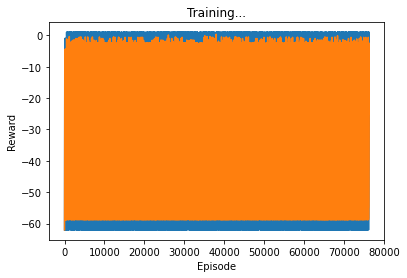

In [294]:
#Train the A2C agent
actor_net.train()
critic_net.train()
ep_rewards=[]
dqnloc_count = [0 for i in range(len(env.tx_locs))]
loc_errors = [np.abs(20*np.log10(np.abs(x))-20*np.log10(np.abs(y))) for x,y in zip(loc_SNRexh, loc_minSNRexh)]
iter_avg_error = []
iter_errors = []
dqn_epslen=[]
outer = tqdm.notebook.tqdm(total=episodes, desc='training loop: ', position=0)


for episode in range(episodes):
    log_probs = [] #log probabilities of actions from actor_net
    values = [] #value from critic_net
    rwd_tensors = []
    done_tensors= []
    entropy = 0
    tx_num = obs_list[episode]
    obs = env.reset(tx_num, ch_randvals[episode], dqnloc_count[tx_num]+1)
    
    
    tx_num = env.get_txloc_ndx(env.tx_loc)
    dqnloc_count[tx_num] +=1
    
    ep_rwd = 0.0
    timestep = 0
    tx_dirs = [-1.0 for x in range(env.action_space.n)]
    rx_dirs = [-1.0 for x in range(env.action_space.n)]
    data_rates =[np.inf for x in range(env.action_space.n)]
    rssi_vals =[np.complex(0,0) for x in range(env.action_space.n)]
    rwd_vals =[-2.0 for x in range(env.action_space.n)]
    
    done = False
    #while not done:
    for i in count():
        #obs = torch.tensor(obs, device=device, dtype=torch.float32)
        obs = torch.FloatTensor(obs).to(device)
        dist, value = actor_net(obs), critic_net(obs)

        action = dist.sample() #action_tensor
        next_obs, reward, done, _ = env.step(action.cpu().numpy())

        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        
        rwd_tensors.append(torch.tensor([reward], dtype=torch.float, device=device))
        done_tensors.append(torch.tensor([1-done], dtype=torch.float, device=device))
        
        tx_dirs[env.txdir_ndx] = env.tx_bdir*180/np.pi
        rx_dirs[env.rbdir_ndx] = env.rx_bdir*180/np.pi
        data_rates[env.txdir_ndx*env.N_rx+env.rbdir_ndx] = env.rate
        rssi_vals[env.txdir_ndx*env.N_rx+env.rbdir_ndx] = env.rssi_val
        #print("action: {}, data rate: {}, rssi_val: {}, datarates: {}, rssi_vals:{}".format(em.env.rbdir_ndx, em.env.rate, em.env.rssi_val, data_rates, rssi_vals))
        
        rwd_vals[env.txdir_ndx*env.N_rx+env.rbdir_ndx] = reward
        ep_rwd += reward
        
        obs = next_obs
        
        
        exh_rssi = loc_SNRexh[tx_num]
        if data_rates[env.txdir_ndx*env.N_rx+env.rbdir_ndx] == np.inf:
            dqn_rssi = loc_minSNRexh[tx_num]
        else:
            dqn_rate = data_rates[env.txdir_ndx*env.N_rx+env.rbdir_ndx]#max(data_rates)
            dqn_rssi = rssi_vals[env.txdir_ndx*env.N_rx+env.rbdir_ndx]
        
        error = np.abs(20*np.log10(np.abs(exh_rssi))-20*np.log10(np.abs(dqn_rssi)))
        iter_errors.append(error)
        loc_errors[tx_num] = error
        iter_avg_error.append(np.mean(loc_errors))
        
        if done:
            print('Episode: {}, Iteration: {}'.format(episode+1, i))
            
            break
    
    next_obs = torch.FloatTensor(next_obs).to(device)
    next_value = critic_net(next_obs)
    
    #compute returns
    R = next_value
    returns = []
    for step in reversed(range(len(rwd_tensors))):
        R = rwd_tensors[step] + GAMMA * R * done_tensors[step]
        returns.insert(0, R)
        
    ep_rewards.extend(returns)
    
    log_probs = torch.cat(log_probs)
    returns = torch.cat(returns).detach()
    values = torch.cat(values)
    
    advantage = returns - values

    #compute loss
    actor_loss = -(log_probs * advantage.detach())#.mean()
    critic_loss = advantage.pow(2)#.mean()
    
    dqn_epslen.append(env.rbdir_count)
    moving_avg_rwd = get_moving_average(len(env.tx_locs), ep_rewards)            
    print('Episode {},\t Score: {:.2f}, moving avg_rwd: {}, actor_loss: {}, critic_loss: {}'.format(episode+1, ep_rwd, moving_avg_rwd[-1], np.mean(actor_loss.data.cpu().numpy()[0]), np.mean(critic_loss.data.cpu().numpy()[0])))
    #plot(episode_rewards, 100)

    print("TX loc: {}".format(env.tx_loc))
    tx_num = env.get_txloc_ndx(env.tx_loc)
    exh_action_ndx = loc_exhbdir[tx_num]
    #print("TX dirs: {}, episode length: {}".format(tx_dirs, len(tx_dirs)))
    #print("RX dirs: {}".format(rx_dirs))
    best_action_ndx = env.txdir_ndx*env.N_rx + env.rbdir_ndx#data_rates.index(max(data_rates))
    print("dqn action ndx: {}, exh action ndx: {}".format(best_action_ndx, exh_action_ndx))
    #print("data rates: ", data_rates)
    #print("rwd vals: ", rwd_vals)
    print("\n\n")

    optimizerA.zero_grad()
    optimizerC.zero_grad()
    actor_loss.backward(torch.ones_like(actor_loss))
    critic_loss.backward(torch.ones_like(critic_loss))
    optimizerA.step()
    optimizerC.step()
    
    # update tqdm bar
    outer.update(1)
    
test_rewards = []
plot(ep_rewards, len(env.tx_locs), test_rewards)

In [295]:
print(np.mean(dqn_epslen))
print(dqn_epslen)

38.096
[64, 64, 64, 64, 64, 64, 64, 64, 6, 1, 64, 4, 64, 50, 64, 32, 64, 9, 47, 1, 16, 64, 64, 64, 6, 28, 25, 5, 2, 1, 50, 15, 63, 29, 64, 12, 11, 56, 64, 12, 15, 14, 64, 8, 64, 3, 64, 64, 57, 64, 64, 33, 11, 17, 64, 4, 59, 64, 64, 6, 12, 64, 64, 4, 64, 22, 64, 11, 13, 38, 64, 38, 43, 2, 64, 8, 34, 10, 14, 48, 64, 25, 64, 7, 6, 64, 60, 18, 35, 50, 64, 19, 10, 17, 64, 17, 14, 5, 64, 2, 24, 23, 64, 7, 3, 17, 61, 3, 9, 61, 64, 47, 4, 58, 64, 20, 12, 42, 64, 12, 21, 53, 64, 5, 36, 40, 64, 17, 64, 7, 64, 12, 33, 43, 64, 2, 64, 64, 64, 8, 31, 4, 64, 18, 64, 23, 64, 15, 27, 64, 64, 11, 9, 16, 64, 52, 29, 4, 63, 2, 64, 14, 64, 7, 7, 64, 64, 64, 64, 32, 64, 35, 64, 13, 64, 18, 45, 64, 64, 16, 16, 6, 64, 2, 20, 35, 64, 14, 4, 64, 64, 45, 64, 61, 64, 4, 64, 12, 64, 44, 36, 8, 64, 1, 15, 25, 64, 15, 43, 64, 64, 13, 7, 8, 47, 43, 64, 64, 64, 26, 9, 44, 64, 64, 64, 9, 64, 12, 8, 29, 64, 30, 11, 4, 64, 27, 64, 63, 64, 64, 64, 8, 64, 10, 6, 24, 64, 64, 50, 9, 64, 16, 41, 6, 64, 15, 23, 27, 64, 6, 17, 

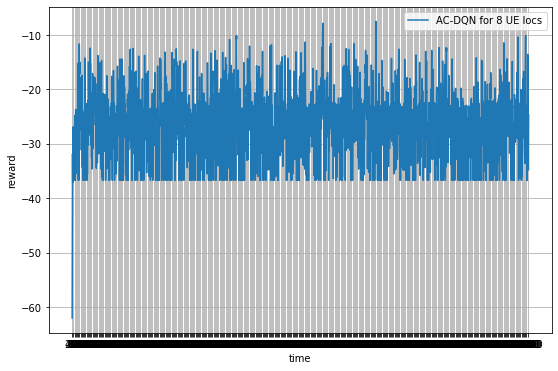

In [296]:
##### from Source.misc_fun.utils import *
fig = plt.figure(figsize=[9, 6])


moving_avg_period = 100

#em.env.obs_space.nvec[3]*len(em.env.tx_locs)
dqn_movingavg = get_moving_average(moving_avg_period, ep_rewards)

#plt.plot(np.arange(1,len(ep2_rewards)+1,1), odqn_movingavg, np.arange(1,len(ep_rewards)+1,1), dqn_movingavg)
#plt.legend(['o-dqn for {} UE locs'.format(len(em2.env.tx_locs)), 'dqn for {} UE locs'.format(len(em.env.tx_locs))])
plt.plot(np.arange(1,len(ep_rewards)+1,1), dqn_movingavg)
plt.legend(['AC-DQN for {} UE locs'.format(len(env.tx_locs))])

#min_ndx=0
#max_ndx=500
#plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.xticks(np.arange(0,len(iter_avg_error), step=200))
plt.grid()

plt.xlabel('time')
plt.ylabel('reward')
#plt.savefig("061120_gdqn_rdqn_rwdplot_avnlosmodel.pdf")
plt.show()
#plt.savefig("071020_cab_dqn_rwdplot_2.pdf")

In [297]:
print(iter_avg_error)

[66.6575203027551, 66.1814744224623, 67.26509312195319, 67.2650931219532, 66.1814744224623, 66.79629402048143, 67.63086625641732, 67.40901033731274, 66.79629402048143, 67.26509312195319, 66.93296445701995, 66.87937622185964, 66.1814744224623, 64.39863162937198, 65.79575752236877, 69.9568920912117, 67.29873759148408, 64.39863162937198, 64.39863162937198, 64.78434852946552, 65.48225032886288, 66.93296445701995, 66.93296445701995, 64.39863162937198, 65.79575752236877, 64.78434852946552, 67.51928308314143, 65.48225032886288, 72.39450109928168, 66.79629402048143, 66.93296445701995, 67.741139002246, 67.741139002246, 69.9568920912117, 69.48084621091893, 66.07330495782143, 67.741139002246, 65.9345312400951, 69.84661934538309, 64.39863162937198, 67.51928308314143, 65.48225032886289, 67.96299492135056, 66.6575203027551, 66.79629402048143, 69.95689209121176, 65.48225032886289, 66.56719132255583, 67.04323720284864, 69.23390302855174, 65.79575752236877, 69.84661934538309, 69.9568920912117, 66.56719

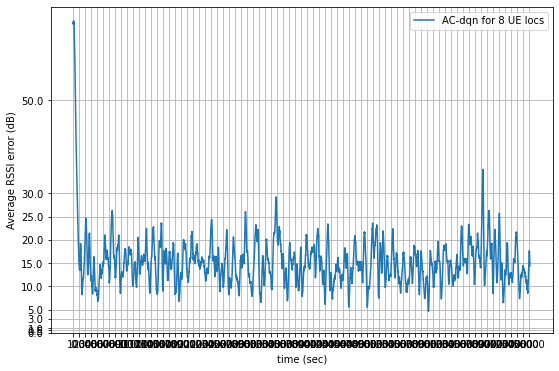

In [298]:
from Source.misc_fun.utils import *
fig = plt.figure(figsize=[9, 6])

#iter_avg_error = iter_avg_error[:2000]
#iter2_avg_error = iter2_avg_error[:2000]

moving_avg_period = 200
dqn_movingavg = get_moving_average(moving_avg_period, iter_avg_error)

#plt.plot(np.arange(1,len(iter2_avg_error)+1,1), odqn_movingavg, np.arange(1,len(iter_avg_error)+1,1), dqn_movingavg)
#plt.legend(['o-dqn for {} UE locs'.format(len(em2.env.tx_locs)), 'dqn for {} UE locs'.format(len(em.env.tx_locs))])
plt.plot(np.arange(1,len(iter_avg_error)+1,1), dqn_movingavg)
plt.legend(['AC-dqn for {} UE locs'.format(len(env.tx_locs))])
#min_ndx=0
#max_ndx=500
#plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.xticks(np.arange(0,len(iter_avg_error), step=1000))
plt.yticks([0,0.5,1,3,5,10,15,20,25,30,50])
plt.grid()
plt.xlabel('time (sec)')
plt.ylabel('Average RSSI error (dB)')
#plt.savefig("061120_gdqn_rdqn_erroplot_avnlosmodel.pdf")
plt.show()
#plt.savefig("071020_cab_dqn_erroplot_2.pdf")